In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184


In [3]:
cast_dtypes = {
    'stock_id': np.int16,
    'date_id': np.int16,
    'seconds_in_bucket': np.int16,
    'imbalance_size': np.float32,
    'imbalance_buy_sell_flag': np.int16,
    'reference_price': np.float32,
    'matched_size': np.float32,
    'far_price': np.float32,
    'near_price': np.float32,
    'bid_price': np.float32,
    'bid_size': np.float32,
    'ask_price': np.float32,
    'ask_size': np.float32,
    'wap': np.float32,
}

display(train_df.dtypes)
train_df = train_df.astype(cast_dtypes)
display(train_df)

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
dtype: object

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010200
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


In [4]:
weights = np.array([
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
])

index_wap = (
    train_df
    .groupby(['date_id', 'seconds_in_bucket'])
    .apply(lambda x: (weights[x['stock_id']] * x['wap']).sum() / weights[x['stock_id']].sum())
)
index_wap = pd.DataFrame(index_wap, columns=['index_wap'])
train_df = train_df.merge(index_wap, on=['date_id', 'seconds_in_bucket'])
display(train_df)

del index_wap
gc.collect()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,index_wap
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704,1.000000
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986,1.000000
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950,1.000000
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010200,1.000000
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276,0.998756
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077,0.998756
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443,0.998756
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184,0.998756


0

In [5]:
def preprocess(df: pl.DataFrame):
    df = pl.from_pandas(df)

    new_features0 = [
        (pl.col('imbalance_size') / 1e+06).name.keep(),
        (pl.col('matched_size') / 1e+06).name.keep(),
        (pl.col('bid_size') / 1e+06).name.keep(),
        (pl.col('ask_size') / 1e+06).name.keep(),
    ]
    new_features1 = [
        (pl.col('ask_price') - pl.col('bid_price')).alias('feature1'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('feature2'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('feature3'),
        (pl.col('ask_price') - pl.col('wap')).alias('feature4'),
        (pl.col('bid_price') - pl.col('wap')).alias('feature5'),
        (pl.col('far_price') - pl.col('near_price')).alias('feature6'),
        (pl.col('far_price') - pl.col('reference_price')).alias('feature7'),
        (pl.col('near_price') - pl.col('reference_price')).alias('feature8'),
        (pl.col('index_wap') - pl.col('reference_price')).alias('feature9'),
        (pl.col('index_wap') - pl.col('ask_price')).alias('feature10'),
        (pl.col('index_wap') - pl.col('bid_price')).alias('feature11'),
        (pl.col('index_wap') - pl.col('far_price')).alias('feature12'),
        (pl.col('index_wap') - pl.col('near_price')).alias('feature13'),
        (pl.col('index_wap') - pl.col('wap')).alias('feature14'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('feature15'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('feature16'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('feature17'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('feature18'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('feature19'),
        (pl.col('far_price') + pl.col('near_price')).alias('feature20'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('feature21'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature22'),
        ((pl.col('ask_price') - pl.col('reference_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature23'),
        ((pl.col('bid_price') - pl.col('reference_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature24'),
        ((pl.col('ask_price') - pl.col('wap')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature25'),
        ((pl.col('bid_price') - pl.col('wap')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature26'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature27'),
        ((pl.col('ask_price') - pl.col('reference_price')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature28'),
        ((pl.col('bid_price') - pl.col('reference_price')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature29'),
        ((pl.col('ask_price') - pl.col('wap')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature30'),
        ((pl.col('bid_price') - pl.col('wap')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature31'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature32'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature33'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature34'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature35'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature36'),
        (pl.col('index_wap') / pl.col('ask_price')).alias('feature37'),
        (pl.col('index_wap') / pl.col('bid_price')).alias('feature38'),
        (pl.col('index_wap') / pl.col('reference_price')).alias('feature39'),
        (pl.col('index_wap') / pl.col('wap')).alias('feature40'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature41'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature42'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature43'),
        (pl.col('bid_size') / pl.col('imbalance_size')).alias('feature44'),
        (pl.col('ask_size') / pl.col('imbalance_size')).alias('feature45'),
        (pl.col('matched_size') / pl.col('imbalance_size')).alias('feature46'),
    ]

    base_features = [
        'imbalance_size',
        'matched_size',
        'reference_price',
        'far_price',
        'near_price',
        'bid_size',
        'bid_price',
        'ask_size',
        'ask_price',
        'wap',
        'index_wap',
    ]
    #base_features += [f'feature{i}' for i in range(22, 47)]
    
    new_features2 = [
        pl.col(base_features).sort_by(['date_id', 'seconds_in_bucket']).pct_change(n=1).over(['stock_id']).name.prefix('pct_change1_'),
        pl.col(base_features).sort_by(['date_id', 'seconds_in_bucket']).pct_change(n=6).over(['stock_id']).name.prefix('pct_change6_'),
        pl.col(base_features).sort_by(['date_id', 'seconds_in_bucket']).pct_change(n=12).over(['stock_id']).name.prefix('pct_change12_'),
    ]

    new_features3 = [
        ((pl.col(feature) - pl.col(feature).mean()) / pl.col(feature).std())
        .over(['date_id', 'seconds_in_bucket'])
        .alias(f'standardized_{feature}')
        for feature in base_features
    ]

    replace_inf = [
        pl.when(pl.col(feature).is_infinite()).then(None).otherwise(pl.col(feature)).name.keep()
        for feature in df.columns
    ]

    df = (
        df
        .with_columns(new_features0)
        .with_columns(new_features1)
        .with_columns(new_features2)
        .with_columns(new_features3)
        .with_columns(replace_inf)
        .sort(['date_id', 'seconds_in_bucket', 'stock_id'])
        .to_pandas()
    )

    return df

In [6]:
#train_df = preprocess(train_df)
train_df = train_df.dropna(subset=['target'])
display(train_df)
display(train_df.dtypes)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,index_wap
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704,1.000000
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986,1.000000
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950,1.000000
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010200,1.000000
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276,0.998756
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077,0.998756
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443,0.998756
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184,0.998756


stock_id                     int16
date_id                      int16
seconds_in_bucket            int16
imbalance_size             float32
imbalance_buy_sell_flag      int16
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float64
index_wap                  float64
dtype: object

## train lightgbm models using cross validation

In [7]:
def train(
        dataset: pd.DataFrame,
        model_params: Dict[str, Any],
        outputs_dir: pathlib.Path,
        step: int,
        gap: int,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    oof_true = []
    oof_pred = []

    train_day_lower_limits = np.arange(0, 360, step+gap)

    mean_best_iteration = 0

    num_folds = 5
    fold_size = 480 // num_folds
    gap = 5

    date_ids = dataset['date_id']

    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size
        if i < num_folds - 1:  # No need to purge after the last fold
            purged_start = end - 2
            purged_end = end + gap + 2
            train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
        else:
            train_indices = (date_ids >= start) & (date_ids < end)

        valid_indices = (date_ids >= end) & (date_ids < end + fold_size)

        print(f'common times: {sum((train_indices.astype(int) - valid_indices.astype(int))==0):,}')

        _, ax = plt.subplots()
        ax.plot(date_ids[train_indices], np.ones(sum(train_indices)), marker='o')
        ax.plot(date_ids[valid_indices], np.zeros(sum(valid_indices)), marker='o')
        ax.set_xlim(0, 480)
        plt.show()
        
        train_X = dataset.loc[train_indices][feature_columns]
        train_y = dataset.loc[train_indices][target_columns]
        valid_X = dataset.loc[valid_indices][feature_columns]
        valid_y = dataset.loc[valid_indices][target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(500),
        ]
        
        train_dataset = lgb.Dataset(
            train_X,
            train_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )

        valid_dataset = lgb.Dataset(
            valid_X,
            valid_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=6000,
        )
        # model.save_model(
        #     outputs_dir.joinpath(f'lightgbm_fold{i+1}.txt'),
        #     num_iteration=model.best_iteration
        # )
        
        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{i+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X, num_iteration=model.best_iteration)
        valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)

        oof_true.append(valid_y['target'])
        oof_pred.append(valid_pred)

        history['train_mae'].append(mean_absolute_error(train_y['target'], train_pred))
        history['valid_mae'].append(mean_absolute_error(valid_y['target'], valid_pred))

        mean_best_iteration += model.best_iteration
        
        del train_X, train_y, train_dataset, valid_X, valid_y, valid_dataset, model, fimp
        del train_pred, valid_pred
        gc.collect()

    history = pd.DataFrame.from_dict(history)

    mean_best_iteration /= len(train_day_lower_limits)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    fimps.index = [f'{len(fimps)-i}_{idx}' for i, idx in enumerate(fimps.index)]
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    test_y_mae = mean_absolute_error(oof_true, oof_pred)
    print(f'test_y mae: {test_y_mae:.4f}')
    
    # with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
    #     yaml.dump(
    #         {
    #             'test_y rmse': test_y_mae,
    #         },
    #         f,
    #         default_flow_style=False
    #     )
    return history, oof_true, oof_pred, fimps, mean_best_iteration

common times: 975,755


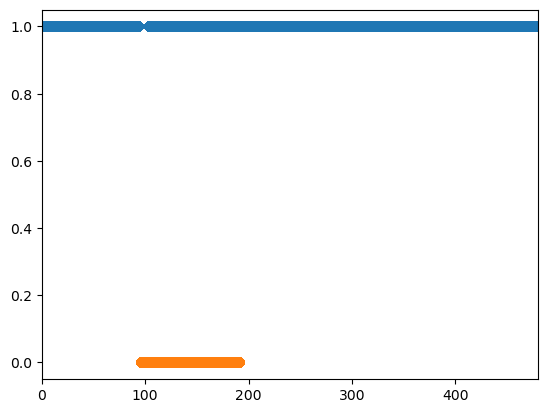

train_X.shape: (5129542, 14), train_y.shape: (5129542, 4)
valid_X.shape: (1040765, 14), valid_y.shape: (1040765, 4)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l1: 6.32577	valid's l1: 7.15453
common times: 2,008,899


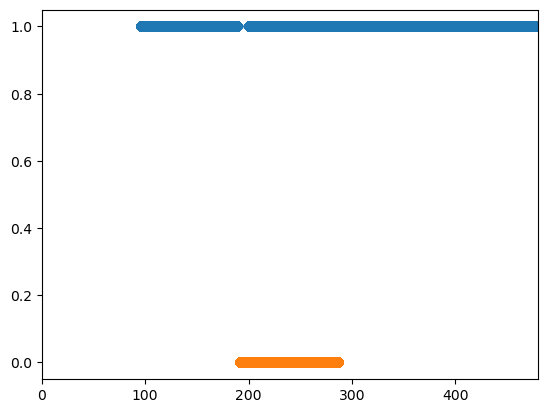

train_X.shape: (4104593, 14), train_y.shape: (4104593, 4)
valid_X.shape: (1050720, 14), valid_y.shape: (1050720, 4)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l1: 6.44064	valid's l1: 6.458
common times: 3,054,503


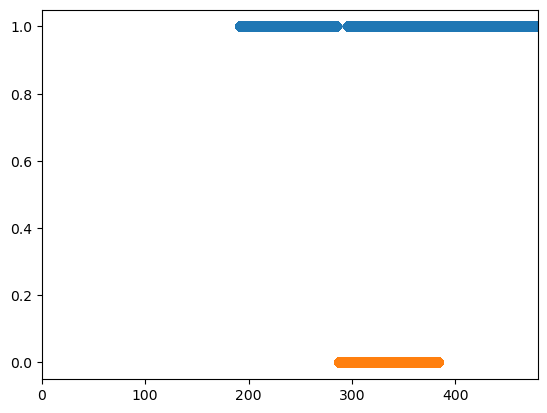

train_X.shape: (3063718, 14), train_y.shape: (3063718, 4)
valid_X.shape: (1055559, 14), valid_y.shape: (1055559, 4)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l1: 6.27947	valid's l1: 6.37125
common times: 4,105,388


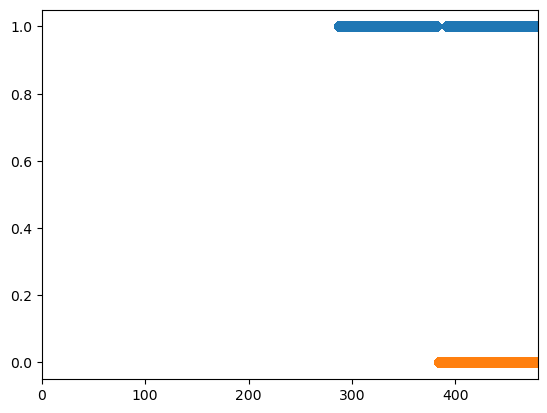

train_X.shape: (2012558, 14), train_y.shape: (2012558, 4)
valid_X.shape: (1055944, 14), valid_y.shape: (1055944, 4)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l1: 6.16158	valid's l1: 6.00897
common times: 4,170,948


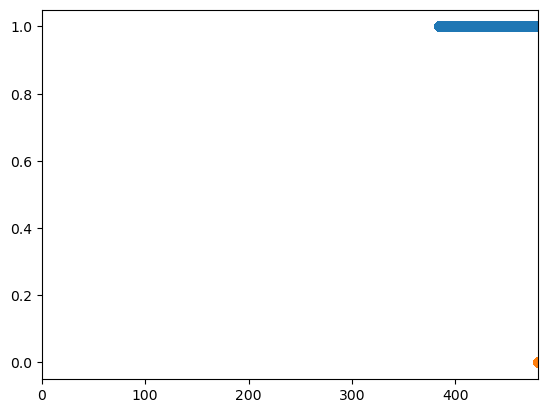

train_X.shape: (1055944, 14), train_y.shape: (1055944, 4)
valid_X.shape: (11000, 14), valid_y.shape: (11000, 4)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l1: 5.99642	valid's l1: 4.85972
test_y mae: 6.4916


In [8]:
params = {
        "objective": "mae",
        "n_estimators": 100,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
#         "learning_rate": 0.00871,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
#         "reg_alpha": 0.1,
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }

step = 60
gap = 0

history, oof_true, oof_pred, fimps, mean_best_iteration = train(
    dataset=train_df,
    model_params=params,
    outputs_dir=outputs_dir_path,
    step=step,
    gap=gap,
)

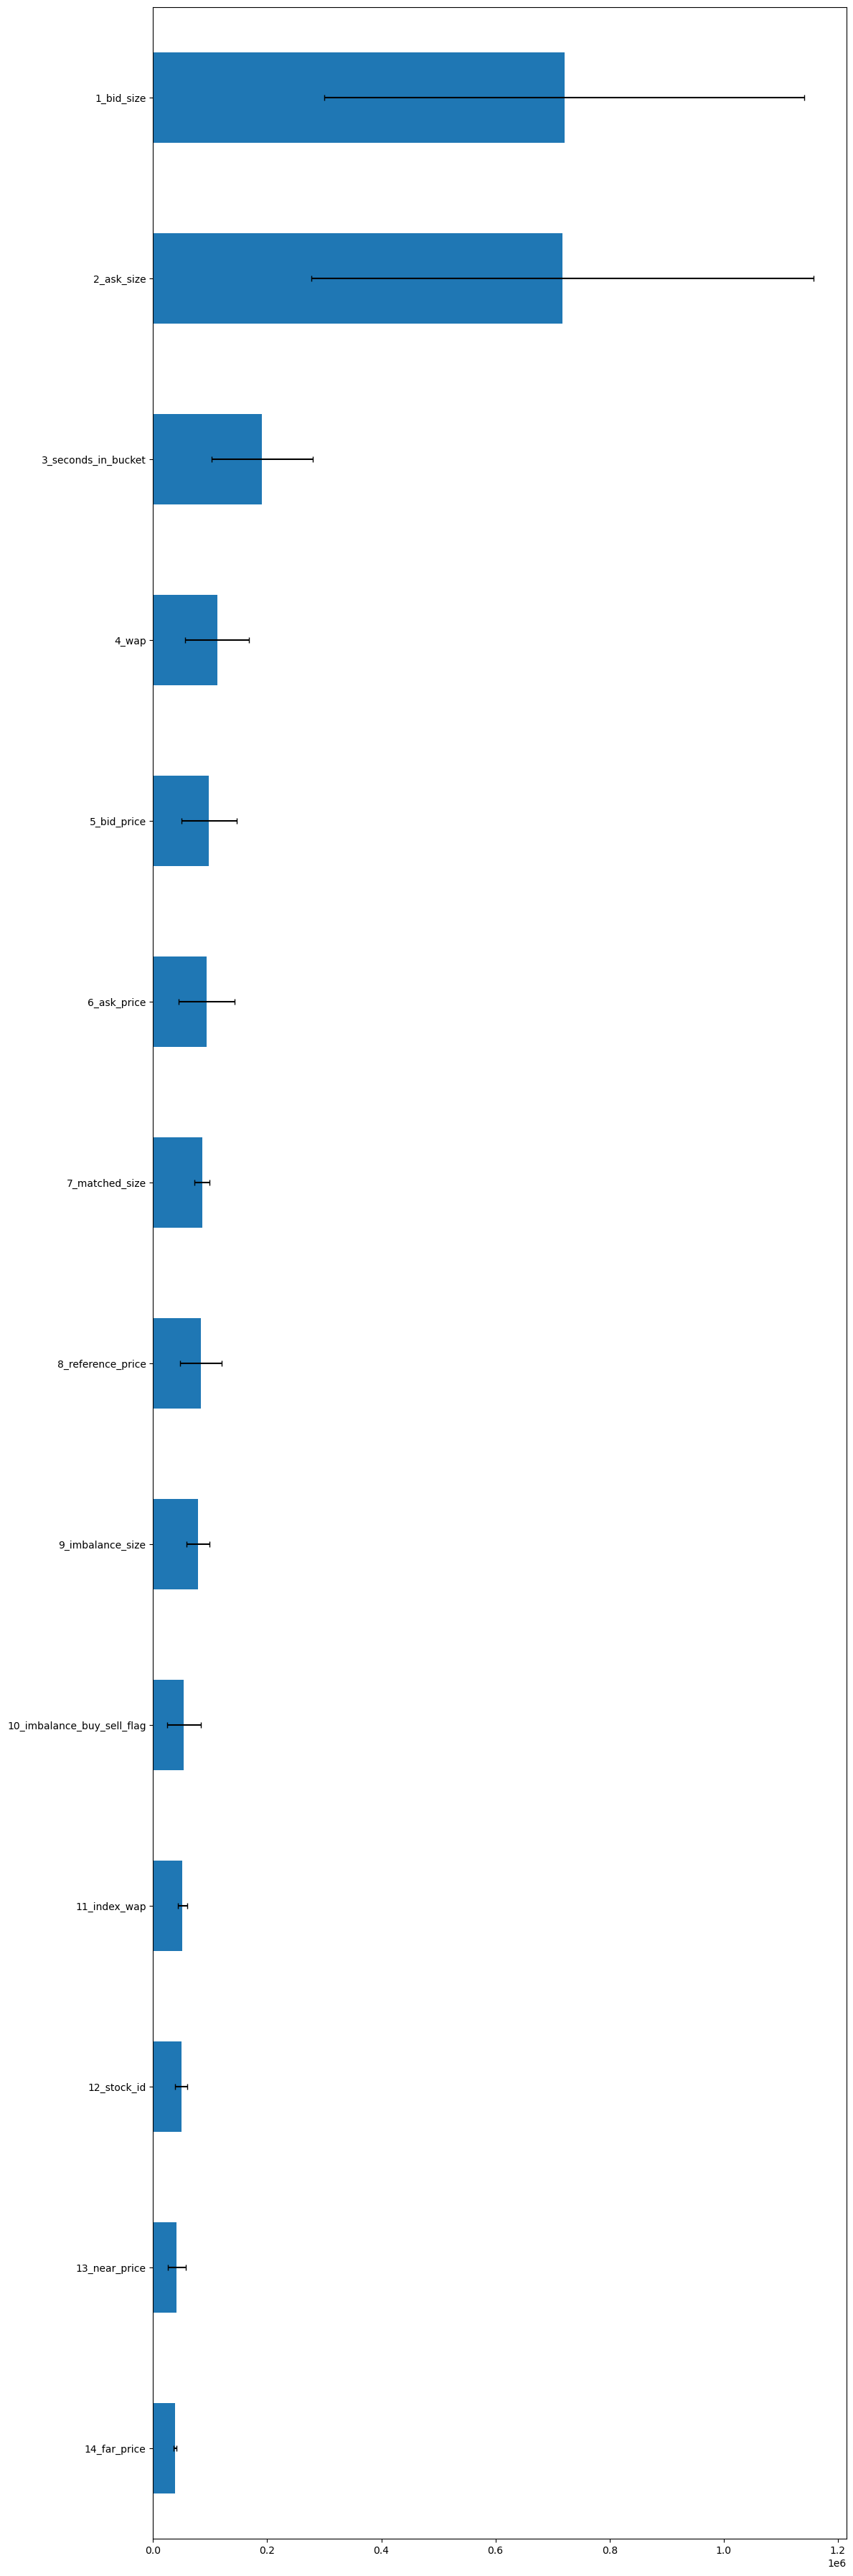

In [9]:
_, ax = plt.subplots(figsize=(12, 36))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)
plt.tight_layout()
plt.show()